# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **learning-rate control (with Reduce on Plateau)**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [14]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Dataset Prototype Control (Important)

To speed up development and debugging, you will use a **balanced prototype version of the Intel training dataset** while building and testing your code.

* **During development:**
  Set `PROTO_TOTAL` to an integer (for example, `1400`) to train on a balanced subset of the training data
  (≈ 10% of the full Intel training set).

* **For your final runs:**
  Set `PROTO_TOTAL = None` (or `0`) to train on the **full training dataset**.

#### Notes

* This setting affects the **training pool** of images used to build `train_ds` and `val_ds`.
* The **validation fraction** (`VAL_FRAC`) is unchanged, but the **validation set will be smaller** when you use a prototype training pool.
* The **test set is unchanged** and is always evaluated on the full test dataset.

#### Before You Submit

Before submitting your notebook, make sure that:

* [ ] `PROTO_TOTAL` is set to `None` (or `0`) so the model is trained on the **full training dataset**
* [ ] Your notebook runs **top to bottom without errors**
* [ ] Training completes successfully using the full dataset

Submissions that leave `PROTO_TOTAL` set to a prototype value will **not** receive full credit.


In [15]:
# Prototype control:
#   - Set PROTO_TOTAL to an integer (e.g., 1400) to use a balanced subset (~10% of Intel train)
#   - Set PROTO_TOTAL to None (or 0) to use the full training set

PROTO_TOTAL = 0   # <-- change to None for full dataset

### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [16]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Training and testing sets already defined, accessed here as global variables

In [18]:
# Uses globals: train_ds, val_ds, test_ds

def train_and_test(model, 
                   epochs=5,
                   lr_schedule=1e-3,
                   optimizer="Adam",
                   title="Learning Curves",
                   batch_size=64,  # kept for API compatibility; ignored if datasets are batched
                   use_early_stopping=True,
                   patience=8,
                   min_delta=1e-4,
                   callbacks=None,
                   verbose=1,
                   return_history=False):

    print(f"\n{title}\n")

    # Choose optimizer
    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer  # assume already an optimizer instance

    # Compile
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=verbose
    )

    extra_cbs = callbacks or []
    cbs = ([early_stop] if use_early_stopping else []) + extra_cbs

    start = time.time()

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=cbs,
        verbose=verbose
    )

    # Best epoch consistent with EarlyStopping monitor
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_acc   = history.history["val_accuracy"][best_epoch]

    plot_learning_curves(history, title=title)

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    end = time.time()
    print(f"\nExecution Time: " + format_hms(end - start))

    if return_history:
        return history


### Load the Intel Image Classification Dataset  



In [19]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [20]:

AUTOTUNE = tf.data.AUTOTUNE

def list_files_and_labels(directory, class_names=None, exts=(".jpg", ".jpeg", ".png")):
    """
    Returns:
      filepaths: np.array[str]
      labels:    np.array[int32]
      class_names_used: list[str] in deterministic order
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        # keep only classes that exist in this directory, preserve given order
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    filepaths = []
    labels = []

    for cname in class_names:
        folder = os.path.join(directory, cname)
        for fname in sorted(os.listdir(folder)):  # deterministic within class
            if fname.lower().endswith(exts):
                filepaths.append(os.path.join(folder, fname))
                labels.append(class_to_idx[cname])

    return np.array(filepaths), np.array(labels, dtype=np.int32), class_names


def stratified_split_indices(y, val_frac=0.2, seed=42):
    """
    Deterministic stratified split over indices.
    Returns: train_idx, val_idx (np arrays)
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)

    train_idx_list = []
    val_idx_list = []

    classes = np.unique(y)
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)
        n_val = int(np.floor(len(idx) * val_frac))
        val_idx_list.append(idx[:n_val])
        train_idx_list.append(idx[n_val:])

    train_idx = np.concatenate(train_idx_list)
    val_idx   = np.concatenate(val_idx_list)

    # shuffle each split deterministically so batches mix classes
    rng.shuffle(train_idx)
    rng.shuffle(val_idx)

    return train_idx, val_idx


def balanced_subset_indices(y, total=None, per_class=None, seed=42, allow_smaller=True):
    """
    Choose a balanced subset of indices.

    Specify exactly one of:
      - total: desired total number of samples across all classes (realized = floor(total/k)*k)
      - per_class: desired samples per class

    Returns:
      subset_idx: np.array of indices into y
    """
    rng = np.random.default_rng(seed)
    y = np.asarray(y)
    classes = np.unique(y)
    k = len(classes)

    if (total is None) == (per_class is None):
        raise ValueError("Specify exactly one of total or per_class.")

    if per_class is None:
        per_class = int(total // k)  # balanced; realized total = per_class * k

    chosen = []
    for c in classes:
        idx = np.flatnonzero(y == c)
        rng.shuffle(idx)

        if len(idx) < per_class:
            if not allow_smaller:
                raise ValueError(f"Class {c} has only {len(idx)} items, need {per_class}.")
            take = len(idx)
        else:
            take = per_class

        chosen.append(idx[:take])

    subset_idx = np.concatenate(chosen)
    rng.shuffle(subset_idx)  # mix classes deterministically
    return subset_idx


def make_image_dataset(filepaths, labels, img_size=(150, 150), batch_size=32,
                       shuffle=False, seed=42, cache_to_disk=None):
    """
    Builds a tf.data.Dataset that loads images lazily from disk.
    - filepaths: np array of strings
    - labels:    np array of int32
    """
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    if shuffle:
        # shuffle file references (cheap), not image tensors
        ds = ds.shuffle(buffer_size=len(filepaths), seed=seed, reshuffle_each_iteration=True)

    def _load_and_preprocess(path, label):
        img_bytes = tf.io.read_file(path)
        img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size, method="bilinear")
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

    ds = ds.map(_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if cache_to_disk is not None:
        ds = ds.cache(cache_to_disk)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


# -------------------------
# Intel dataset loading (with optional balanced prototype subset)
# -------------------------

IMG_SIZE    = (150, 150)
INPUT_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE  = 32
VAL_FRAC    = 0.2
SEED        = random_seed  # use your existing seed

# 1) List train files/labels deterministically
train_files_all, train_labels_all, class_names = list_files_and_labels(train_dir)
num_classes = len(class_names)

# 2) Optional: take a balanced prototype subset (no images loaded yet)
if PROTO_TOTAL is not None and PROTO_TOTAL > 0:
    proto_idx = balanced_subset_indices(train_labels_all, total=PROTO_TOTAL, seed=SEED)
    train_files  = train_files_all[proto_idx]
    train_labels = train_labels_all[proto_idx]
else:
    train_files  = train_files_all
    train_labels = train_labels_all

# Report realized size (balanced)
per_class = len(train_files) // num_classes
print(f"Train pool: {len(train_files)} images ({per_class} per class), classes={num_classes}")

# 3) Stratified deterministic split of indices (still no images loaded)
train_idx, val_idx = stratified_split_indices(train_labels, val_frac=VAL_FRAC, seed=SEED)

# 4) Slice file lists for train/val
files_train = train_files[train_idx]
y_train     = train_labels[train_idx]
files_val   = train_files[val_idx]
y_val       = train_labels[val_idx]

print(f"Split sizes: train={len(files_train)}, val={len(files_val)} (VAL_FRAC={VAL_FRAC})")

# 5) Build datasets (lazy image loading)
train_ds = make_image_dataset(files_train, y_train, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=True, seed=SEED,
                              cache_to_disk=None)  # or "/tmp/train_cache"

val_ds   = make_image_dataset(files_val, y_val, img_size=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False,
                              cache_to_disk=None)  # or "/tmp/val_cache"

# 6) Test set: keep same class mapping as train
test_files, test_labels, _ = list_files_and_labels(test_dir, class_names=class_names)

# Possible but not recommended: prototype the test set too (balanced). Set to None for full test.
PROTO_TEST_TOTAL = None
if PROTO_TEST_TOTAL is not None and PROTO_TEST_TOTAL > 0:
    test_idx = balanced_subset_indices(test_labels, total=PROTO_TEST_TOTAL, seed=SEED)
    test_files  = test_files[test_idx]
    test_labels = test_labels[test_idx]
    print(f"Test pool: {len(test_files)} images ({len(test_files)//num_classes} per class)")

test_ds = make_image_dataset(test_files, test_labels, img_size=IMG_SIZE,
                             batch_size=BATCH_SIZE, shuffle=False,
                             cache_to_disk=None)


Train pool: 14034 images (2339 per class), classes=6
Split sizes: train=11230, val=2804 (VAL_FRAC=0.2)


### Examine The Dataset

In [21]:

def show_counts_from_labels(name, labels, class_names):
    c = Counter(labels.tolist())
    counts = {class_names[k]: c.get(k, 0) for k in range(len(class_names))}
    print(f"{name} per-class counts:", counts)

print("class_names:", class_names)
print("train examples:", len(files_train), "val examples:", len(files_val), "test examples:", len(test_files))

show_counts_from_labels("train", y_train, class_names)
show_counts_from_labels("val",   y_val,   class_names)
show_counts_from_labels("test",  test_labels, class_names)


class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train examples: 11230 val examples: 2804 test examples: 3000
train per-class counts: {'buildings': 1753, 'forest': 1817, 'glacier': 1924, 'mountain': 2010, 'sea': 1820, 'street': 1906}
val per-class counts: {'buildings': 438, 'forest': 454, 'glacier': 480, 'mountain': 502, 'sea': 454, 'street': 476}
test per-class counts: {'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


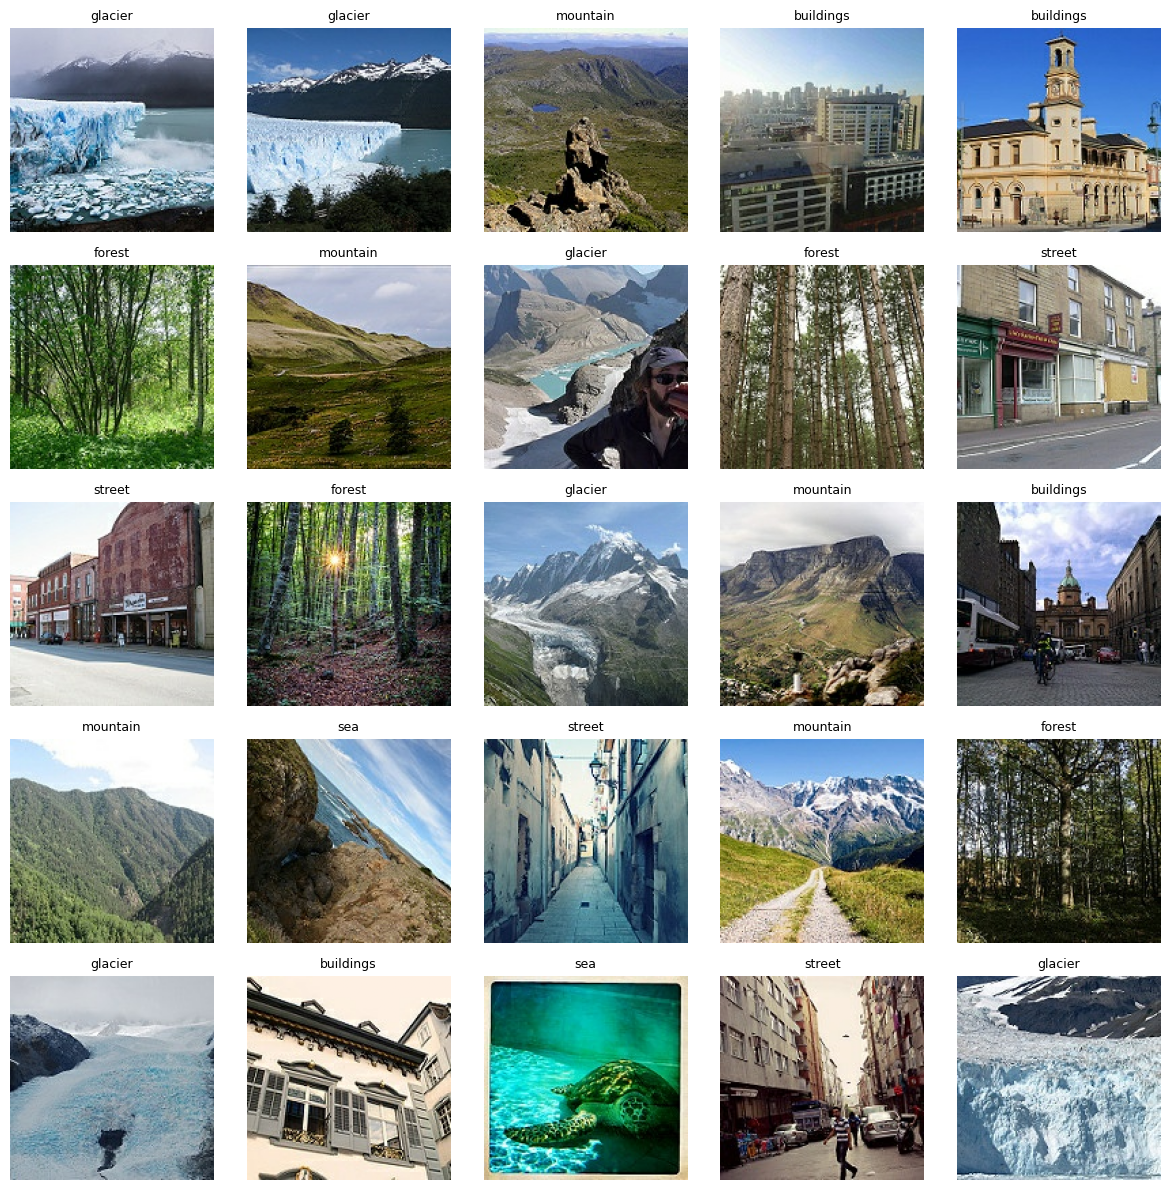

In [22]:
# Show 25 sample images

plt.figure(figsize=(12, 12))

# Take one batch from the dataset
images, labels = next(iter(train_ds))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[int(labels[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Learning Rate Schedulers

In [23]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=3,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-7,           # Lower bound on the learning rate.
    verbose=1,             # 0: quiet, 1: update messages.
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).

> **NOTE:** MobileNetV2 ImageNet weights were trained at 224×224.
> We use 150×150 for faster training; this is valid because the backbone is fully convolutional
> when include_top=False (weights transfer to different input sizes).
>
> You may safely ignore the warning: "UserWarning: `input_shape` is undefined or non-square, ...."

In [24]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=INPUT_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

/tmp/ipython-input-966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(


Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [25]:
# Ha, this is very long!

# base.summary()

/tmp/ipython-input-966669238.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = mobilenet_v2.MobileNetV2(



Model Baseline

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 244s 683ms/step - accuracy: 0.7674 - loss: 0.6120 - val_accuracy: 0.8902 - val_loss: 0.3042
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 273s 778ms/step - accuracy: 0.9037 - loss: 0.2653 - val_accuracy: 0.8951 - val_loss: 0.2851
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 240s 684ms/step - accuracy: 0.9133 - loss: 0.2412 - val_accuracy: 0.8980 - val_loss: 0.2875
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 295s 778ms/step - accuracy: 0.9226 - loss: 0.2127 - val_accuracy: 0.8980 - val_loss: 0.2831
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 270s 770ms/step - accuracy: 0.9325 - loss: 0.1888 - val_accuracy: 0.8891 - val_loss: 0.3079
Restoring model weights from the end of the best epoch: 4.


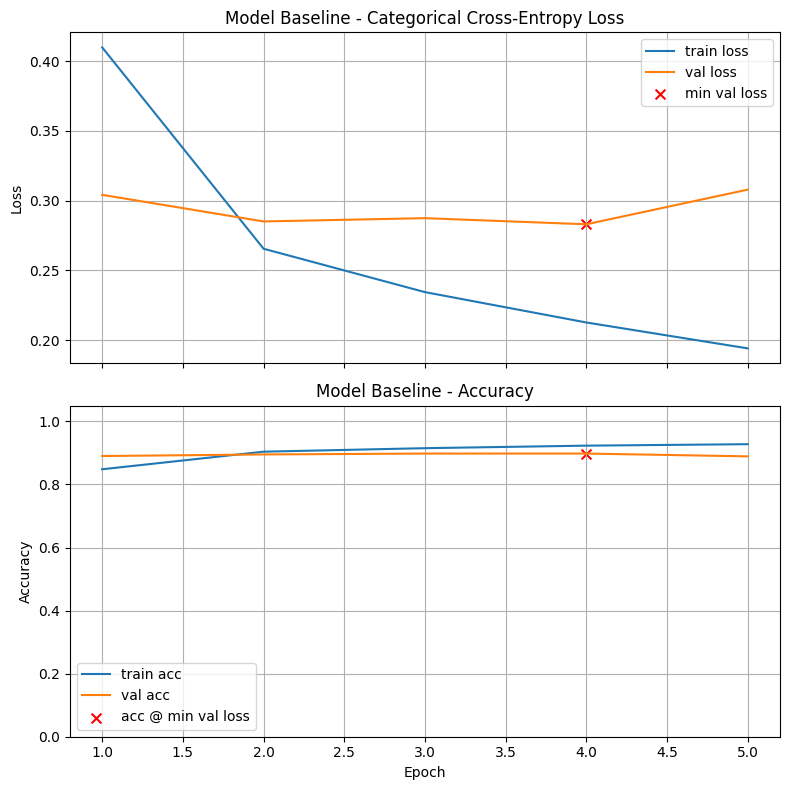

Final Training Loss:            0.1941
Final Training Accuracy:        0.9277
Final Validation Loss:          0.3079
Final Validation Accuracy:      0.8891
Minimum Validation Loss:        0.2831 (Epoch 4)
Validation Accuracy @ Min Loss: 0.8980

Test Loss: 0.2793
Test Accuracy: 0.8980

Validation-Test Gap (accuracy): 0.000003

Execution Time: 00:22:53


In [26]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  # use your Intel num_classes (6)
])

train_and_test(model_baseline, title="Model Baseline")

### Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled(trainable=False)  # MobileNetV2(include_top=False, pooling="avg")
```

This backbone already applies **Global Average Pooling** and outputs a **1280-D** feature vector per image.
Do **not** unfreeze any backbone layers and do **not** add another pooling layer.

### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate:** fixed LR
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads.
5. **Answer the graded questions.**

### Notes / Constraints

* With `pooling="avg"`, the head receives a tensor of shape **(None, 1280)** → **do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


/tmp/ipython-input-4083419482.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(



P1-Frozen-Linear

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 243s 679ms/step - accuracy: 0.2578 - loss: 1.7313 - val_accuracy: 0.4226 - val_loss: 1.4812 - learning_rate: 0.0010
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 295s 773ms/step - accuracy: 0.4372 - loss: 1.4472 - val_accuracy: 0.5178 - val_loss: 1.3130 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 269s 768ms/step - accuracy: 0.4964 - loss: 1.3169 - val_accuracy: 0.5357 - val_loss: 1.2514 - learning_rate: 0.0010
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 272s 777ms/step - accuracy: 0.5218 - loss: 1.2485 - val_accuracy: 0.5264 - val_loss: 1.2071 - learning_rate: 0.0010
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 240s 685ms/step - accuracy: 0.5468 - loss: 1.2055 - val_accuracy: 0.5770 - val_loss: 1.1501 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


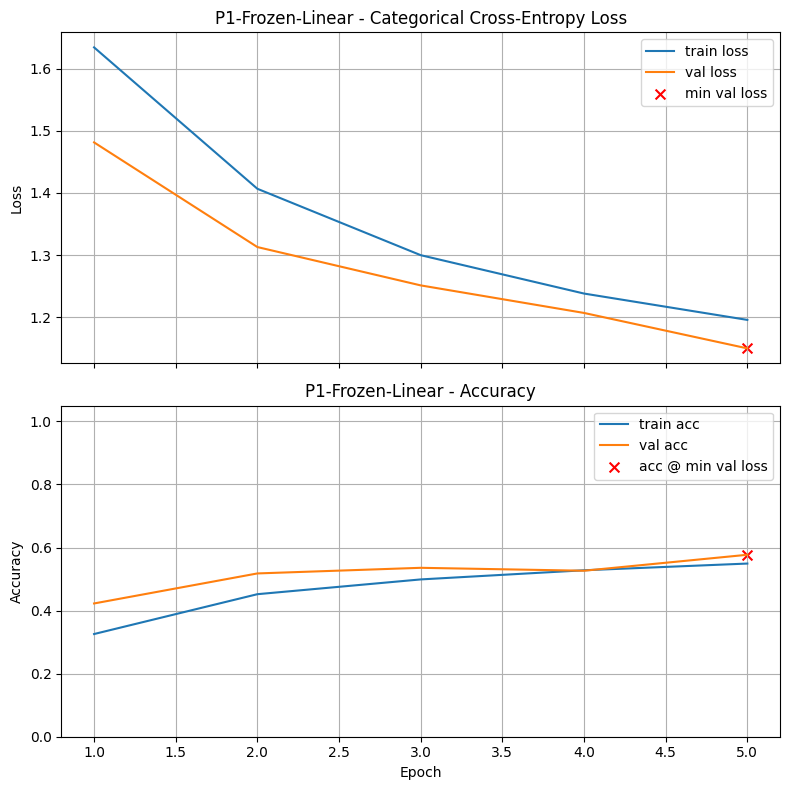

Final Training Loss:            1.1959
Final Training Accuracy:        0.5492
Final Validation Loss:          1.1501
Final Validation Accuracy:      0.5770
Minimum Validation Loss:        1.1501 (Epoch 5)
Validation Accuracy @ Min Loss: 0.5770

Test Loss: 1.1771
Test Accuracy: 0.5660

Validation-Test Gap (accuracy): 0.011033

Execution Time: 00:23:43

P1-Frozen-DenseDropout

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 278s 779ms/step - accuracy: 0.2547 - loss: 1.7506 - val_accuracy: 0.4397 - val_loss: 1.4168 - learning_rate: 0.0010
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 281s 802ms/step - accuracy: 0.3744 - loss: 1.4563 - val_accuracy: 0.4344 - val_loss: 1.3139 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 246s 699ms/step - accuracy: 0.4049 - loss: 1.3825 - val_accuracy: 0.4815 - val_loss: 1.2297 - learning_rate: 0.0010
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 279s 795ms/step - accuracy: 0.4221 - loss: 1.3360 - val_accuracy: 0.4765 - val_loss: 1.2134 - learning_rate: 0.0010
Ep

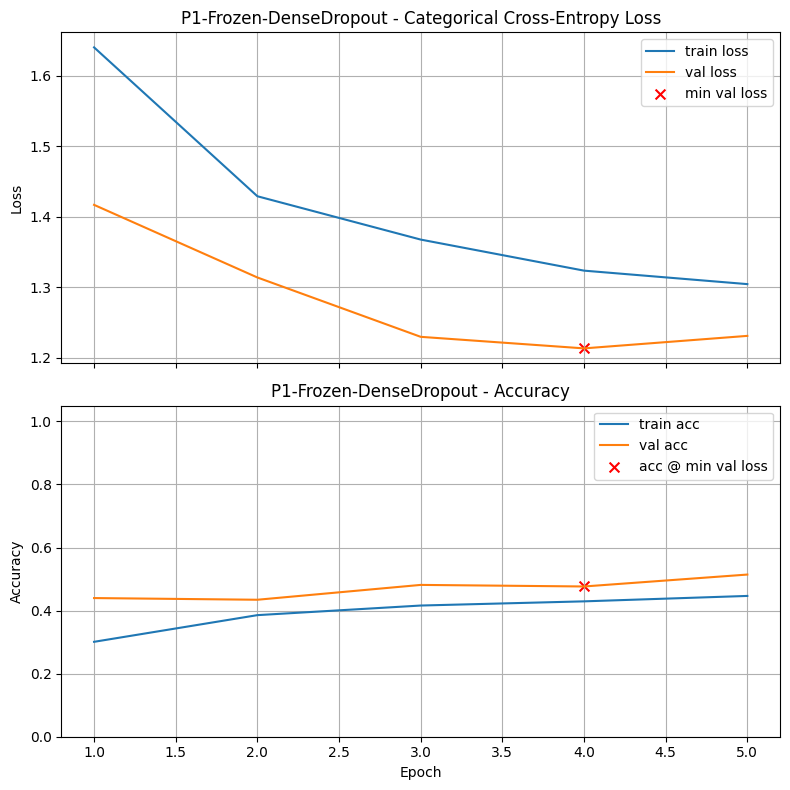

Final Training Loss:            1.3045
Final Training Accuracy:        0.4465
Final Validation Loss:          1.2311
Final Validation Accuracy:      0.5143
Minimum Validation Loss:        1.2134 (Epoch 4)
Validation Accuracy @ Min Loss: 0.4765

Test Loss: 1.2370
Test Accuracy: 0.4537

Validation-Test Gap (accuracy): 0.022796

Execution Time: 00:23:37

P1-Frozen-BN-DenseDropout-L2

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 298s 830ms/step - accuracy: 0.5634 - loss: 1.2061 - val_accuracy: 0.2011 - val_loss: 3.5340 - learning_rate: 0.0010
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 244s 696ms/step - accuracy: 0.6740 - loss: 0.8956 - val_accuracy: 0.4793 - val_loss: 2.1371 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 279s 795ms/step - accuracy: 0.6918 - loss: 0.8406 - val_accuracy: 0.3848 - val_loss: 3.4709 - learning_rate: 0.0010
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 246s 700ms/step - accuracy: 0.7073 - loss: 0.8233 - val_accuracy: 0.4686 - val_loss: 2.6504 - learning_rate: 0.0

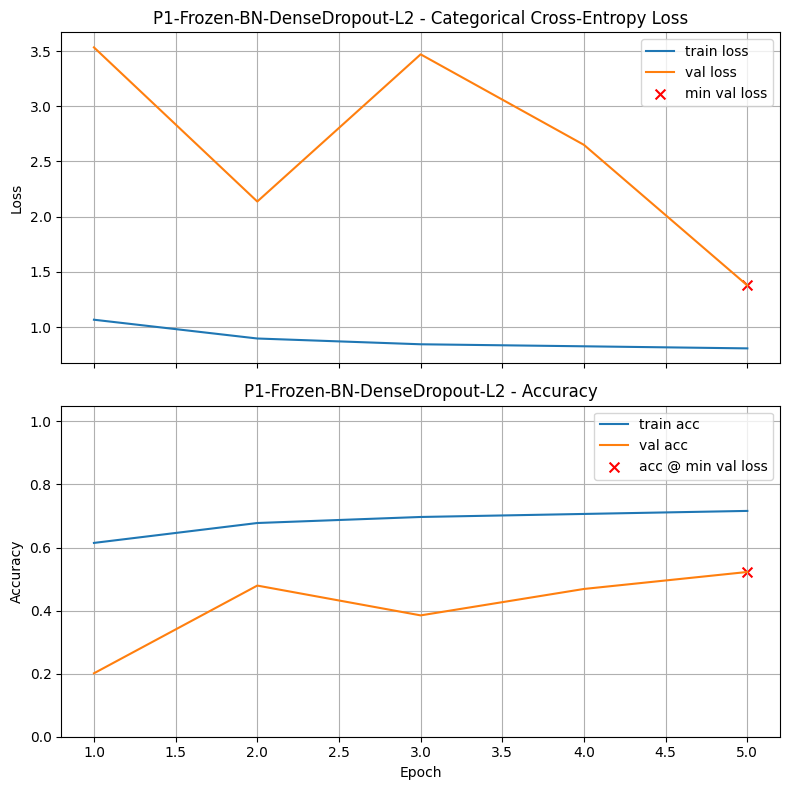

Final Training Loss:            0.8063
Final Training Accuracy:        0.7161
Final Validation Loss:          1.3770
Final Validation Accuracy:      0.5225
Minimum Validation Loss:        1.3770 (Epoch 5)
Validation Accuracy @ Min Loss: 0.5225

Test Loss: 1.3831
Test Accuracy: 0.4993

Validation-Test Gap (accuracy): 0.023135

Execution Time: 00:23:54

P1-Frozen-2Layer

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 289s 804ms/step - accuracy: 0.1894 - loss: 1.9128 - val_accuracy: 0.3588 - val_loss: 1.5533 - learning_rate: 0.0010
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 279s 795ms/step - accuracy: 0.2984 - loss: 1.5983 - val_accuracy: 0.4108 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3057 - loss: 1.5539

In [ ]:
# Your code here; add as many cells as you need

# =========================
# Frozen MobileNetV2
# =========================

def build_mnv2_transfer_model(
    head_type="linear",
    base_trainable=False,
    dense_units=256,
    dropout=0.3,
    l2_strength=1e-4
):
    """
    Builds MobileNetV2 + head.
    Important: applies mobilenet_v2.preprocess_input to match ImageNet training.
    """
    inputs = Input(shape=INPUT_SHAPE)
    x = layers.Lambda(mobilenet_v2.preprocess_input, name="mnv2_preprocess")(inputs)

    base = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=INPUT_SHAPE,
        pooling="avg"          # outputs 1280-d vector
    )
    base.trainable = base_trainable

    x = base(x)

    # ----- heads -----
    if head_type == "linear":
        # minimal head: softmax only
        outputs = Dense(num_classes, activation="softmax")(x)

    elif head_type == "dense_dropout":
        x = Dense(dense_units, activation="relu")(x)
        x = Dropout(dropout)(x)
        outputs = Dense(num_classes, activation="softmax")(x)

    elif head_type == "bn_dense_dropout_l2":
        x = Dense(
            dense_units,
            activation=None,
            kernel_regularizer=regularizers.l2(l2_strength)
        )(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Dropout(dropout)(x)
        outputs = Dense(num_classes, activation="softmax")(x)

    elif head_type == "2layer":
        x = Dense(
            dense_units,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength)
        )(x)
        x = Dropout(dropout)(x)
        x = Dense(
            dense_units // 2,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_strength)
        )(x)
        x = Dropout(dropout)(x)
        outputs = Dense(num_classes, activation="softmax")(x)

    else:
        raise ValueError(f"Unknown head_type: {head_type}")

    model = models.Model(inputs, outputs, name=f"mnv2_{head_type}")
    return model



p1_models = [
    ("P1-Frozen-Linear",                 dict(head_type="linear")),
    ("P1-Frozen-DenseDropout",           dict(head_type="dense_dropout", dense_units=256, dropout=0.4)),
    ("P1-Frozen-BN-DenseDropout-L2",     dict(head_type="bn_dense_dropout_l2", dense_units=256, dropout=0.4, l2_strength=1e-4)),
    ("P1-Frozen-2Layer",                 dict(head_type="2layer", dense_units=512, dropout=0.5, l2_strength=1e-4)),
]

for title, cfg in p1_models:
    model = build_mnv2_transfer_model(base_trainable=False, **cfg)
    train_and_test(
        model,
        title=title,
        epochs=5,
        lr_schedule=1e-3,
        callbacks=[reduce_lr],
        patience=8,
        verbose=1
    )

print("\nTop results so far:")
print_results()

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.

**Your paragraph here (5pts):**

**Validation Accuracy here (15 pts):**

In [14]:
# Set a1 to the validation accuracy found by your best model for this problem. 

a1 = 0.0             # Replace 0.0 with your answer

In [26]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1:.4f}') 


a1 = 0.0000


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—do not add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **fully unfrozen**. Vary one or more of the following:

   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * training stability,
   * convergence behavior,
   * and validation performance trends.

   Use these runs to **narrow down reasonable configurations**, not to identify a single “optimal” setting.

3. **Select one configuration** and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* When fine-tuning a fully unfrozen pretrained model, it is common to use a **much smaller learning rate** (e.g., $1\times10^{-5}$ to $3\times10^{-5}$).
* Small changes in relative performance between the prototype and full dataset are expected. 


In [ ]:
# Your code here; add as many cells as you need

# =========================
# Fine-tune the whole MobileNetV2
# =========================

# Choose your best head from Problem 1:
# (Change this if a different P1 head won in your runs.)
BEST_P1_HEAD = dict(head_type="bn_dense_dropout_l2", dense_units=256, dropout=0.4, l2_strength=1e-4)

# Build model with backbone trainable
model_p2 = build_mnv2_transfer_model(base_trainable=True, **BEST_P1_HEAD)

train_and_test(
    model_p2,
    title="P2-UnfreezeAll-SmallLR",
    epochs=5,
    lr_schedule=1e-5,       
    callbacks=[reduce_lr],
    patience=6,
    verbose=1
)

print("\nTop results so far:")
print_results()

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your paragraph here (5 pts):**





**Validation accuracy here (15 pts):**

In [17]:
# Set a2 to the validation accuracy found by your best model for this problem. 

a2 = 0.0             # Replace 0.0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.0000


## Problem Three — Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$ layers** to fine-tune.
(In Problem 4 you’ll explore unfreezing the top **K MobileNetV2 blocks** instead.)

**Setup.** Your backbone is **MobileNetV2** with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating the model, unfreeze the top $N$ layers using the following approach:

```python
N = 20
model = make_base_model_pooled()
base_model.trainable = True
for layer in base_model.layers[:-N]:
    layer.trainable = False
```

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen**. Vary one or more of the following:

   * $N \in {20, 40, 80}$
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the three experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more layers are unfrozen,
   * training stability and convergence,
   * and validation performance trends.

   Use these runs to **understand the effect of partial unfreezing**, not to identify a single globally optimal configuration.

3. **Select one configuration** (choice of $N$ and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* As more layers are unfrozen, the model typically becomes **more sensitive to learning rate**.
* Learning rates in the range of approximately $1\times10^{-5}$ to $3\times10^{-5}$ are often appropriate for partial fine-tuning, but experimentation is encouraged.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [ ]:
# Your code here; add as many cells as you need

# =========================
# Unfreeze only the top N layers
# =========================

def set_trainable_top_n(model, n_last=40):

    # Find the backbone inside the model
    backbone = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and layer.name.startswith("mobilenetv2"):
            backbone = layer
            break
    if backbone is None:
     
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name:
                backbone = layer
                break
    if backbone is None:
        raise RuntimeError("Could not find MobileNetV2 backbone inside the model.")

    # First freeze all
    for l in backbone.layers:
        l.trainable = False

    # Unfreeze last N (except BatchNorm)
    for l in backbone.layers[-n_last:]:
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True

    return backbone


# Build with backbone trainable=True
model_p3 = build_mnv2_transfer_model(base_trainable=True, **BEST_P1_HEAD)

# Try a few N values
for N in [20, 40, 80]:
    _ = set_trainable_top_n(model_p3, n_last=N)

    # Recompile happens inside train_and_test, so we just call it
    train_and_test(
        model_p3,
        title=f"P3-TopN-{N}-SmallLR",
        epochs=5,
        lr_schedule=1e-5,
        callbacks=[reduce_lr],
        patience=6,
        verbose=1
    )

print("\nTop results so far:")
print_results()

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your paragraph here (5pts):**




**Validation accuracy here (15 pts):**

In [20]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = 0.0             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.0000


## Problem Four — Unfreezing Convolution Blocks

**Goal.** Fine-tune MobileNetV2 by unfreezing the **last $K$ convolutional stages/blocks** (rather than unfreezing the last $N$ individual layers as in Problem 3). This gives you a more “semantic” way to control how much of the backbone adapts.

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model, unfreeze the top $K$ blocks using the following approach:

```python
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',   # final 1×1 conv stage before pooling
]

K = 3

model = make_base_model_pooled(trainable=False)

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # Often recommended to keep BN frozen during fine-tuning
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])
```

### To Do:

1. **Design at least three experiments** with the model having the **last $K$ stages unfrozen**. Vary one or more of the following:

   * $K \in {1, 2, 3, 5}$ *(K counts stages/blocks, not individual layers)*
   * **BatchNormalization strategy:** keep BN frozen vs. unfreeze BN.
   * **Head choice** (select one from Problem 1).
   * **Learning-rate:** fixed LR
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR).

2. **Run and compare** the experiments **using the prototype training dataset**, focusing on:

   * how performance changes as more blocks are unfrozen,
   * whether unfreezing BN helps or destabilizes training,
   * and validation performance trends and stability.

   Use these runs to **understand the effect of block-level fine-tuning** and to narrow down reasonable configurations.

3. **Select one configuration** (choice of $K$, BN strategy, and training strategy) and **retrain it on the full training dataset**, then use this run when answering the graded questions.

### Notes

* Your backbone was built with `pooling="avg"` → **do not** add another `GlobalAveragePooling2D()`.
* Unfreezing more blocks usually requires a **smaller learning rate** and can increase training instability; this is part of what you are investigating.
* Small shifts in relative performance between the prototype and full dataset are expected.


In [ ]:
# Your code here; add as many cells as you need

# =========================
# Unfreeze the top K MobileNetV2 blocks
# =========================

def set_trainable_top_k_blocks(model, k_blocks=3):
    """
    Unfreezes the last k_blocks inverted-residual blocks of MobileNetV2.
    Also unfreezes the final Conv_1 stage.
    Keeps BatchNorm frozen (recommended).
    """
    # Locate backbone
    backbone = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name:
            backbone = layer
            break
    if backbone is None:
        raise RuntimeError("Could not find MobileNetV2 backbone inside the model.")

    # Identify available block ids (usually 0..16)
    block_ids = sorted({
        int(l.name.split('_')[1])
        for l in backbone.layers
        if l.name.startswith("block_") and "_" in l.name
    })
    if not block_ids:
        raise RuntimeError("No block_* layers found; unexpected backbone naming.")
    max_block = max(block_ids)

    # Determine threshold: unfreeze blocks >= (max_block - k_blocks + 1)
    threshold = max_block - k_blocks + 1

    for l in backbone.layers:
        # default freeze
        l.trainable = False

        # unfreeze last K blocks + Conv_1 (+ its followups)
        name = l.name
        is_last_k_block = name.startswith("block_") and int(name.split("_")[1]) >= threshold
        is_conv1_stage  = name.startswith("Conv_1") or name.startswith("Conv_1_bn") or name.startswith("out_relu")

        if is_last_k_block or is_conv1_stage:
            if isinstance(l, tf.keras.layers.BatchNormalization):
                l.trainable = False
            else:
                l.trainable = True

    return backbone, threshold, max_block


model_p4 = build_mnv2_transfer_model(base_trainable=True, **BEST_P1_HEAD)

for K in [2, 3, 5]:
    backbone, thr, mx = set_trainable_top_k_blocks(model_p4, k_blocks=K)
    print(f"\nUnfreezing last K={K} blocks (block_{thr}..block_{mx}) + Conv_1 stage")

    train_and_test(
        model_p4,
        title=f"P4-TopKBlocks-{K}-SmallLR",
        epochs=5,
        lr_schedule=1e-5,
        callbacks=[reduce_lr],
        patience=6,
        verbose=1
    )

print("\nFinal leaderboard:")
print_results()

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your paragraph here (5pts):**




**Validation accuracy (15pts):**

In [23]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 = 0.0             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.0000


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [25]:
# Print out summary of validation accuracy for each experiment

print_results()

Model Baseline                          	0.8804	8


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments run on the full dataset, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your paragraph here (5pts):**





## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

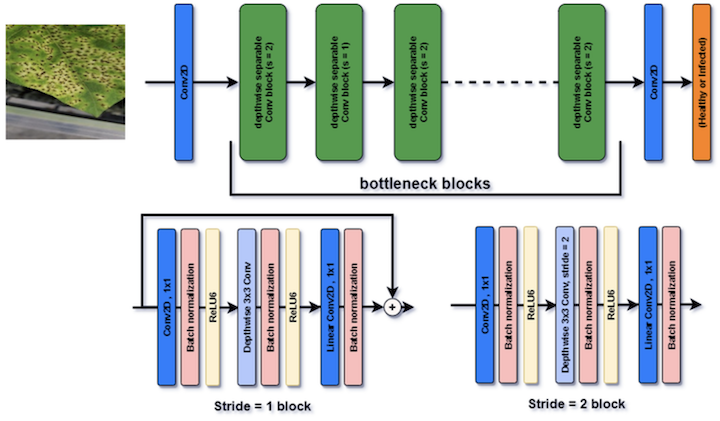


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
